In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import configs as c

In [2]:

for birthyear in list(range(1935, 1961)):
    # Check if there is a previous numpy file matching the same sex and race and cancer site
    list_of_files = glob.glob(f'{c.PATHS["calibration"]}{c.COHORT_SEX}_{c.COHORT_RACE}_*{c.CANCER_SITES[0]}_*.npy')
    # break
    if len(list_of_files) == 0: # Check if there is a previous numpy file matching the same sex and cancer site
        list_of_files = glob.glob(f'{c.PATHS["calibration"]}{c.COHORT_SEX}_*{c.CANCER_SITES[0]}_*.npy')
    if len(list_of_files) == 0: # Check if there is a previous numpy file matching the same race and cancer site
        list_of_files = glob.glob(f'{c.PATHS["calibration"]}{c.COHORT_RACE}_*{c.CANCER_SITES[0]}_*.npy')
    if len(list_of_files) == 0: # Check if there is a previous numpy file matching the same cancer site
        list_of_files = glob.glob(f'{c.PATHS["calibration"]}*{c.CANCER_SITES[0]}_*.npy')
    if len(list_of_files) == 0:
        raise ValueError("No suitable LOAD_LATEST file, set LOAD_LATEST to FALSE")

    # Look at all the unique cohort years in the file names
    all_cohort_years = []
    for file in list_of_files:
        year = file.split('_')[2] # grabs the cohort year
        if int(year) not in all_cohort_years:
            all_cohort_years.append(int(year))
    # Sort ascending years
    all_cohort_years.sort()
    # Get the max calibrated cohort year that is just below or equal to the COHORT_YEAR
    for year in all_cohort_years:
        if year <= birthyear:
            max_year = year
    final_list = []
    for file in list_of_files:
        if f'_{max_year}_' in file:
            final_list.append(file)

    # # Read the latest file
    latest_file = max(final_list, key=os.path.getctime)
    CANCER_PDF = np.load(latest_file)
    # first_zero_index = np.where(CANCER_PDF == 0)[0][0]
    pdf_before_40 = CANCER_PDF[18:40]
    min_before_40 = min(pdf_before_40)
    min_idx =np.argmin(pdf_before_40)+18
    CANCER_PDF[:18] = 0
    CANCER_PDF[18:min_idx] = min_before_40
    new_filename = '-'.join(latest_file.split('-')[:-1]+['60.npy'])
    np.save(new_filename, CANCER_PDF)
    print(latest_file)
    

../outputs/calibration\Female_Black_1935_Lung_2024-08-04_01-30-60.npy
../outputs/calibration\Female_Black_1936_Lung_2024-08-04_01-27-60.npy
../outputs/calibration\Female_Black_1937_Lung_2024-08-04_01-26-60.npy
../outputs/calibration\Female_Black_1938_Lung_2024-08-04_01-28-60.npy
../outputs/calibration\Female_Black_1939_Lung_2024-08-04_01-27-60.npy
../outputs/calibration\Female_Black_1940_Lung_2024-08-04_01-27-60.npy
../outputs/calibration\Female_Black_1941_Lung_2024-08-04_01-26-60.npy
../outputs/calibration\Female_Black_1942_Lung_2024-08-04_01-27-60.npy
../outputs/calibration\Female_Black_1943_Lung_2024-08-04_01-27-60.npy
../outputs/calibration\Female_Black_1944_Lung_2024-08-04_01-27-60.npy
../outputs/calibration\Female_Black_1945_Lung_2024-08-04_04-49-60.npy
../outputs/calibration\Female_Black_1946_Lung_2024-08-04_04-48-60.npy
../outputs/calibration\Female_Black_1947_Lung_2024-08-04_04-49-60.npy
../outputs/calibration\Female_Black_1948_Lung_2024-08-04_04-51-60.npy
../outputs/calibrati

In [3]:
from classes import *
import pandas as pd
import pickle
from tqdm import tqdm

In [5]:
for COHORT_YEAR in tqdm(list(range(1935,1961))):
    ac_cdf, min_age, max_age, CANCER_PDF, cancer_surv_arr, cancer_surv_arr_ed, CANCER_INC = c.select_cohort(COHORT_YEAR, c.COHORT_SEX, c.COHORT_RACE)
    model = DiscreteEventSimulation(ac_cdf, cancer_surv_arr, cancer_surv_arr_ed, len(c.CANCER_SITES))
    # print(objective(model.run(CANCER_PDF).cancerIncArr, min_age, max_age, CANCER_INC))

    # Output model incidence, cancer count, alive count
    df = pd.DataFrame(model.cancerIncArr, columns = ['Incidence'])
    df['Cancer_Count'] = model.cancerCountArr
    df['Alive_Count'] = model.aliveCountArr
    df.to_excel(c.PATHS['output'] + f"{COHORT_YEAR}_{c.COHORT_SEX}_{c.COHORT_RACE}_{c.CANCER_SITES[0]}_SUMMARY.xlsx")

    with open(c.PATHS['output'] + f"{COHORT_YEAR}_{c.COHORT_SEX}_{c.COHORT_RACE}_{c.CANCER_SITES[0]}_LOG.pickle", 'wb') as handle:
        pickle.dump(model.log, handle)

    # Limit the plot's y-axis to just above the highest SEER incidence
    plt.plot(np.arange(c.START_AGE, c.END_AGE), model.run(CANCER_PDF).cancerIncArr[:-1], label='Model', color='blue')
    plt.plot(np.arange(min_age, max_age+1), CANCER_INC, label='SEER', color='darkred', alpha=0.5)
    plt.legend(loc='upper left')
    plt.ylim(0, CANCER_INC.max() + 30)
    plt.xlabel('Age')
    plt.ylabel('Incidence (per 100k)')
    plt.title(f"Cancer Incidence by Age for Birthyear={COHORT_YEAR}, Sex={c.COHORT_SEX}, Race={c.COHORT_RACE}, Site={c.CANCER_SITES[0]}")
    plt.savefig(c.PATHS['plots_calibration'] + f"{c.COHORT_SEX}_{c.COHORT_RACE}_{COHORT_YEAR}_{c.CANCER_SITES[0]}.png", bbox_inches='tight')
    plt.clf()

100%|██████████| 26/26 [02:45<00:00,  6.37s/it]


<Figure size 640x480 with 0 Axes>

In [8]:
CANCER_PDF = np.load('../outputs/calibration/Male_White_1947_Pancreas_2024-08-01_18-49-60.npy')

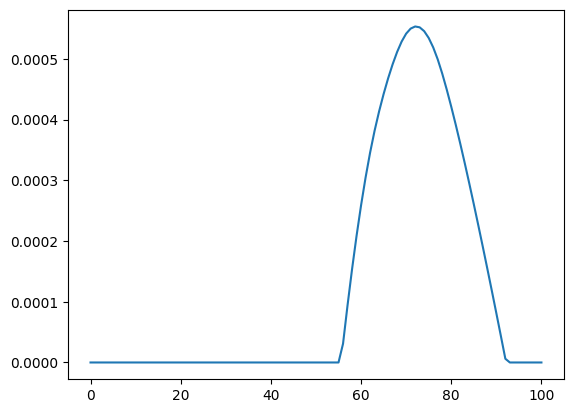

In [9]:
import matplotlib.pyplot as plt

plt.plot(CANCER_PDF)

In [15]:
CANCER_PDF[:31] = 0

In [16]:
CANCER_PDF

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00015502, 0.00045588, 0.0007971 , 0.00117951, 0.00160396,
       0.00206967, 0.00256925, 0.00309364, 0.0036338 , 0.00418012,
       0.00472065, 0.0052436 , 0.00574012, 0.00620212, 0.0066221 ,
       0.00699483, 0.0073157 , 0.00758017, 0.00778375, 0.00792321,
       0.00800005, 0.00801703, 0.007977  , 0.00788287, 0.00773767,
       0.0075446 , 0.00730746, 0.00703025, 0.00671703, 0.00637

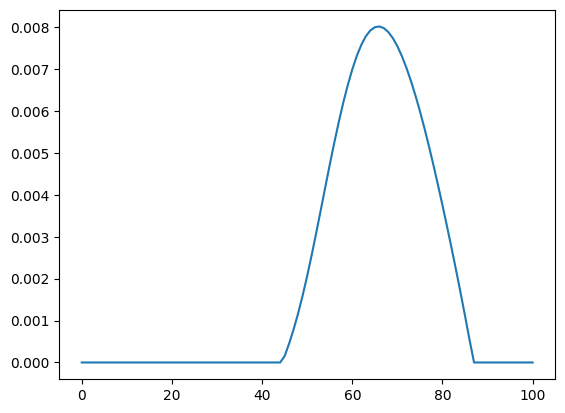

In [17]:
plt.plot(CANCER_PDF)

In [18]:
np.save('../outputs/calibration/Male_Black_1952_Prostate_2024-08-06_18-28-29.npy', CANCER_PDF)